In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from matplotlib import rcParams
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

FIGSIZE = 20, 10

In [2]:
df_tv = pd.read_csv('data/train.csv', index_col='PassengerId')
df_tt = pd.read_csv('data/test.csv', index_col='PassengerId')

df_tv.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
df_tv.Pclass = df_tv.Pclass.map({1: 'one', 2: 'two', 3: 'three'})
df_tt.Pclass = df_tt.Pclass.map({1: 'one', 2: 'two', 3: 'three'})
df_tv.drop('Ticket', axis=1, inplace=True)
df_tt.drop('Ticket', axis=1, inplace=True)

In [4]:
df_tv.describe(include='number')

,Survived,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208
std,0.486592,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df_tv.describe(include='object')

,Pclass,Name,Sex,Cabin,Embarked
count,891,891,891,204,889
unique,3,891,2,147,3
top,three,"Braund, Mr. Owen Harris",male,B96 B98,S
freq,491,1,577,4,644


In [6]:
print(df_tv.isna().sum())
print('*' * 50)
print(df_tt.isna().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64
**************************************************
Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Fare          1
Cabin       327
Embarked      0
dtype: int64


In [7]:
df_tv.mode().iloc[0]

Survived                    0.0
Pclass                    three
Name        Abbing, Mr. Anthony
Sex                        male
Age                        24.0
SibSp                       0.0
Parch                       0.0
Fare                       8.05
Cabin                   B96 B98
Embarked                      S
Name: 0, dtype: object

In [8]:
df_tv.Cabin = df_tv.Cabin.apply(lambda x: np.nan if x is np.nan else x[0])
df_tt.Cabin = df_tt.Cabin.apply(lambda x: np.nan if x is np.nan else x[0])

df_tv['Title'] = df_tv.Name.apply(lambda x: x.split(', ')[1].split()[0][:-1])
df_tt['Title'] = df_tt.Name.apply(lambda x: x.split(', ')[1].split()[0][:-1])

df_tv.Title = df_tv.Title.apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Others')
df_tt.Title = df_tt.Title.apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Others')

df_tv.drop('Name', axis=1, inplace=True)
df_tt.drop('Name', axis=1, inplace=True)

In [9]:
df_tv.fillna(df_tv.mode().iloc[0], inplace=True)
df_tt.fillna(df_tv.mode().iloc[0], inplace=True)

In [10]:
df_tv['FamilySize'] = df_tv.SibSp + df_tv.Parch + 1
df_tt['FamilySize'] = df_tt.SibSp + df_tt.Parch + 1

df_tv.drop(['SibSp', 'Parch'], axis=1, inplace=True)
df_tt.drop(['SibSp', 'Parch'], axis=1, inplace=True)

<Figure size 1440x720 with 0 Axes>

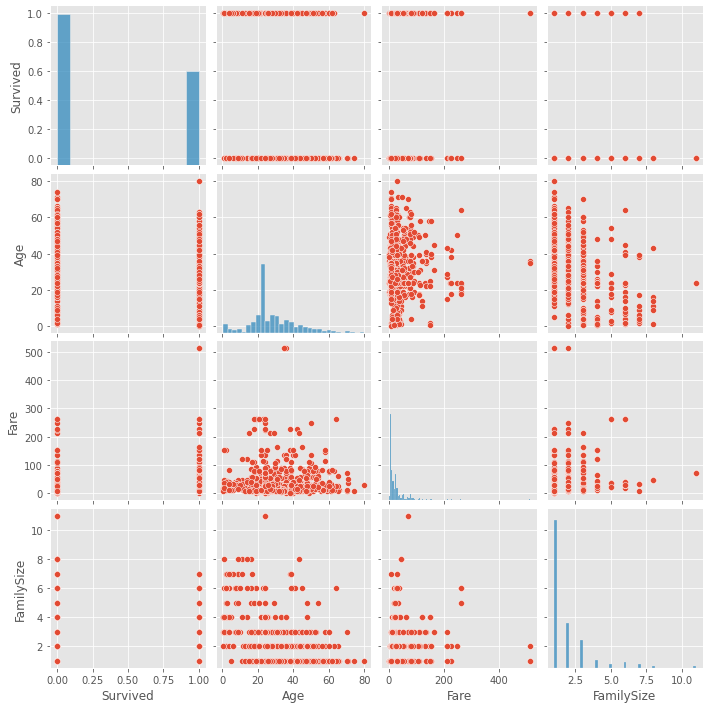

In [11]:
plt.figure(figsize=FIGSIZE)
sns.pairplot(df_tv)

In [12]:
df_tv['LogFare'] = np.log10(df_tv.Fare+1)
df_tt['LogFare'] = np.log10(df_tt.Fare+1)
df_tv.drop('Fare', axis=1, inplace=True)
df_tt.drop('Fare', axis=1, inplace=True)

In [13]:
df_tv.var()

Survived        0.236772
Age           174.228695
FamilySize      2.603248
LogFare         0.177117
dtype: float64

In [14]:
num_columns = df_tt.select_dtypes(include='number').columns
df_tv[num_columns] /= df_tv[num_columns].max()
df_tt[num_columns] /= df_tt[num_columns].max()

In [15]:
df_tv.var()

Survived      0.236772
Age           0.027223
FamilySize    0.021514
LogFare       0.024110
dtype: float64

In [16]:
ohe = OneHotEncoder(drop='first')
cat_columns = df_tv.select_dtypes(include='object').columns
ohe.fit(df_tv[cat_columns])
enc_columns = ohe.get_feature_names_out().tolist()
df_tv[enc_columns] = ohe.transform(df_tv[cat_columns]).toarray()
df_tt[enc_columns] = ohe.transform(df_tt[cat_columns]).toarray()
df_tv.drop(cat_columns, axis=1, inplace=True)
df_tt.drop(cat_columns, axis=1, inplace=True)

In [17]:
df_tv.to_csv('data/train_preprocessed.csv')
df_tt.to_csv('data/test_preprocessed.csv')